In [3]:
using Revise
includet("../scripts/ma_comp.jl")

In [4]:
using GLMakie
using CairoMakie
using JLD2
using GraphvizDotLang: attr
using GraphvizDotLang

# Setup

In [3]:
# meta graph plotting
function metagraph_kwargs(mg::MetaGraph{C,G,L,VD,ED}) where {C,G,L,VD,ED}
    rslt = (;
        nlabels=string.(getindex.(Ref(mg), labels(mg))),
    )
    if ED <: Number
        rslt = (;
            elabels=[(@sprintf "%.3g" mg[src,dst]) for (src,dst) in edge_labels(mg)],
            edge_color=[mg[src,dst] for (src,dst) in edge_labels(mg)],
            rslt...
        )
    else
        rslt = (;
            elabels=[string(mg[src,dst]) for (src,dst) in edge_labels(mg)],
            rslt...
        )
    end
    rslt
end
function metagraphplot(mg; kwargs...)
    graphplot(mg; metagraph_kwargs(mg)..., kwargs...)
end
function metagraphplot!(ax, mg; kwargs...)
    graphplot!(ax, mg; metagraph_kwargs(mg)..., kwargs...)
end

metagraphplot! (generic function with 1 method)

# Make ma_compgraph plots

In [44]:
codes = filter(c->c!=204, collect(0:255)); # skip the no-enzyme rule
for L in 2:5
    @time accg = make_full_singlestate_compgraph(L, codes;
        transprob_threshold=0.9,
        keep_max_only=false
    )
    @time cg = reduce_allcodes_compgraph(accg);

    # Make sure all the transitions really are with probability 1
    for (s, d) in edge_labels(cg)
        xx = cg[s,d]
        if abs(1. - xx[2]) > 100*eps()
            @error "having a significantly non-one transprob in cg"
        end
    end

    skip_singles = L >= 6
    @time gvplot = gv_compgraph_sccs(cg;
        skip_singles,
    ) |> attr(:graph; layout="dot", rankdir="TB")

    GraphvizDotLang.save(gvplot,
        datadir("ma_compgraphs", (@sprintf "L%d.png" L));
        format="png"
    )

    @printf "Done with %d\n" L
end

  0.265204 seconds (214.35 k allocations: 13.658 MiB, 91.49% compilation time)
  0.000020 seconds (32 allocations: 3.328 KiB)
  0.000104 seconds (174 allocations: 13.680 KiB)
Done with 2
  0.037880 seconds (214.03 k allocations: 8.138 MiB)
  0.000041 seconds (53 allocations: 6.859 KiB)
  0.000098 seconds (361 allocations: 28.273 KiB)
Done with 3
  0.176855 seconds (1.12 M allocations: 29.656 MiB)
  0.000120 seconds (94 allocations: 21.688 KiB)
  0.000213 seconds (968 allocations: 78.453 KiB)
Done with 4
  0.713072 seconds (7.21 M allocations: 141.850 MiB)
  0.000257 seconds (165 allocations: 59.812 KiB)
  0.000315 seconds (1.33 k allocations: 108.008 KiB)
Done with 5


# Second version

In [11]:
L = 6
# randcodes = rand(0:255, 20)
randcodes = filter(c->c!=204, collect(0:255));

In [12]:
accg = make_full_singlestate_compgraph(L, randcodes;
    transprob_threshold=0.9,
    keep_max_only=false
)
cg = reduce_allcodes_compgraph(accg);

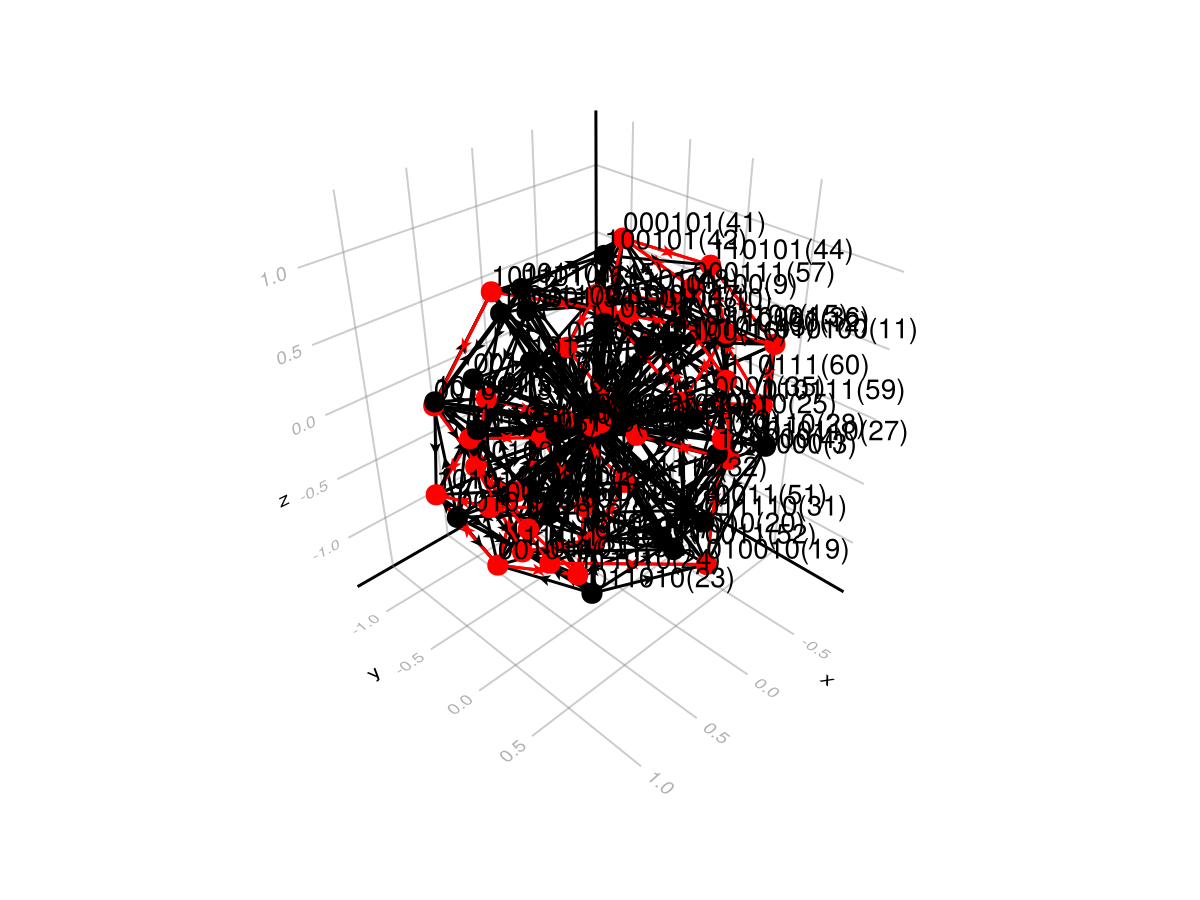

In [13]:
f = plot_compgraph(cg;
    layout=Spring(dim=3),
    # elabels=:codeonly,
    highlight_sccs_kwargs(cg)...
)
# display(GLMakie.Screen(), f)
f

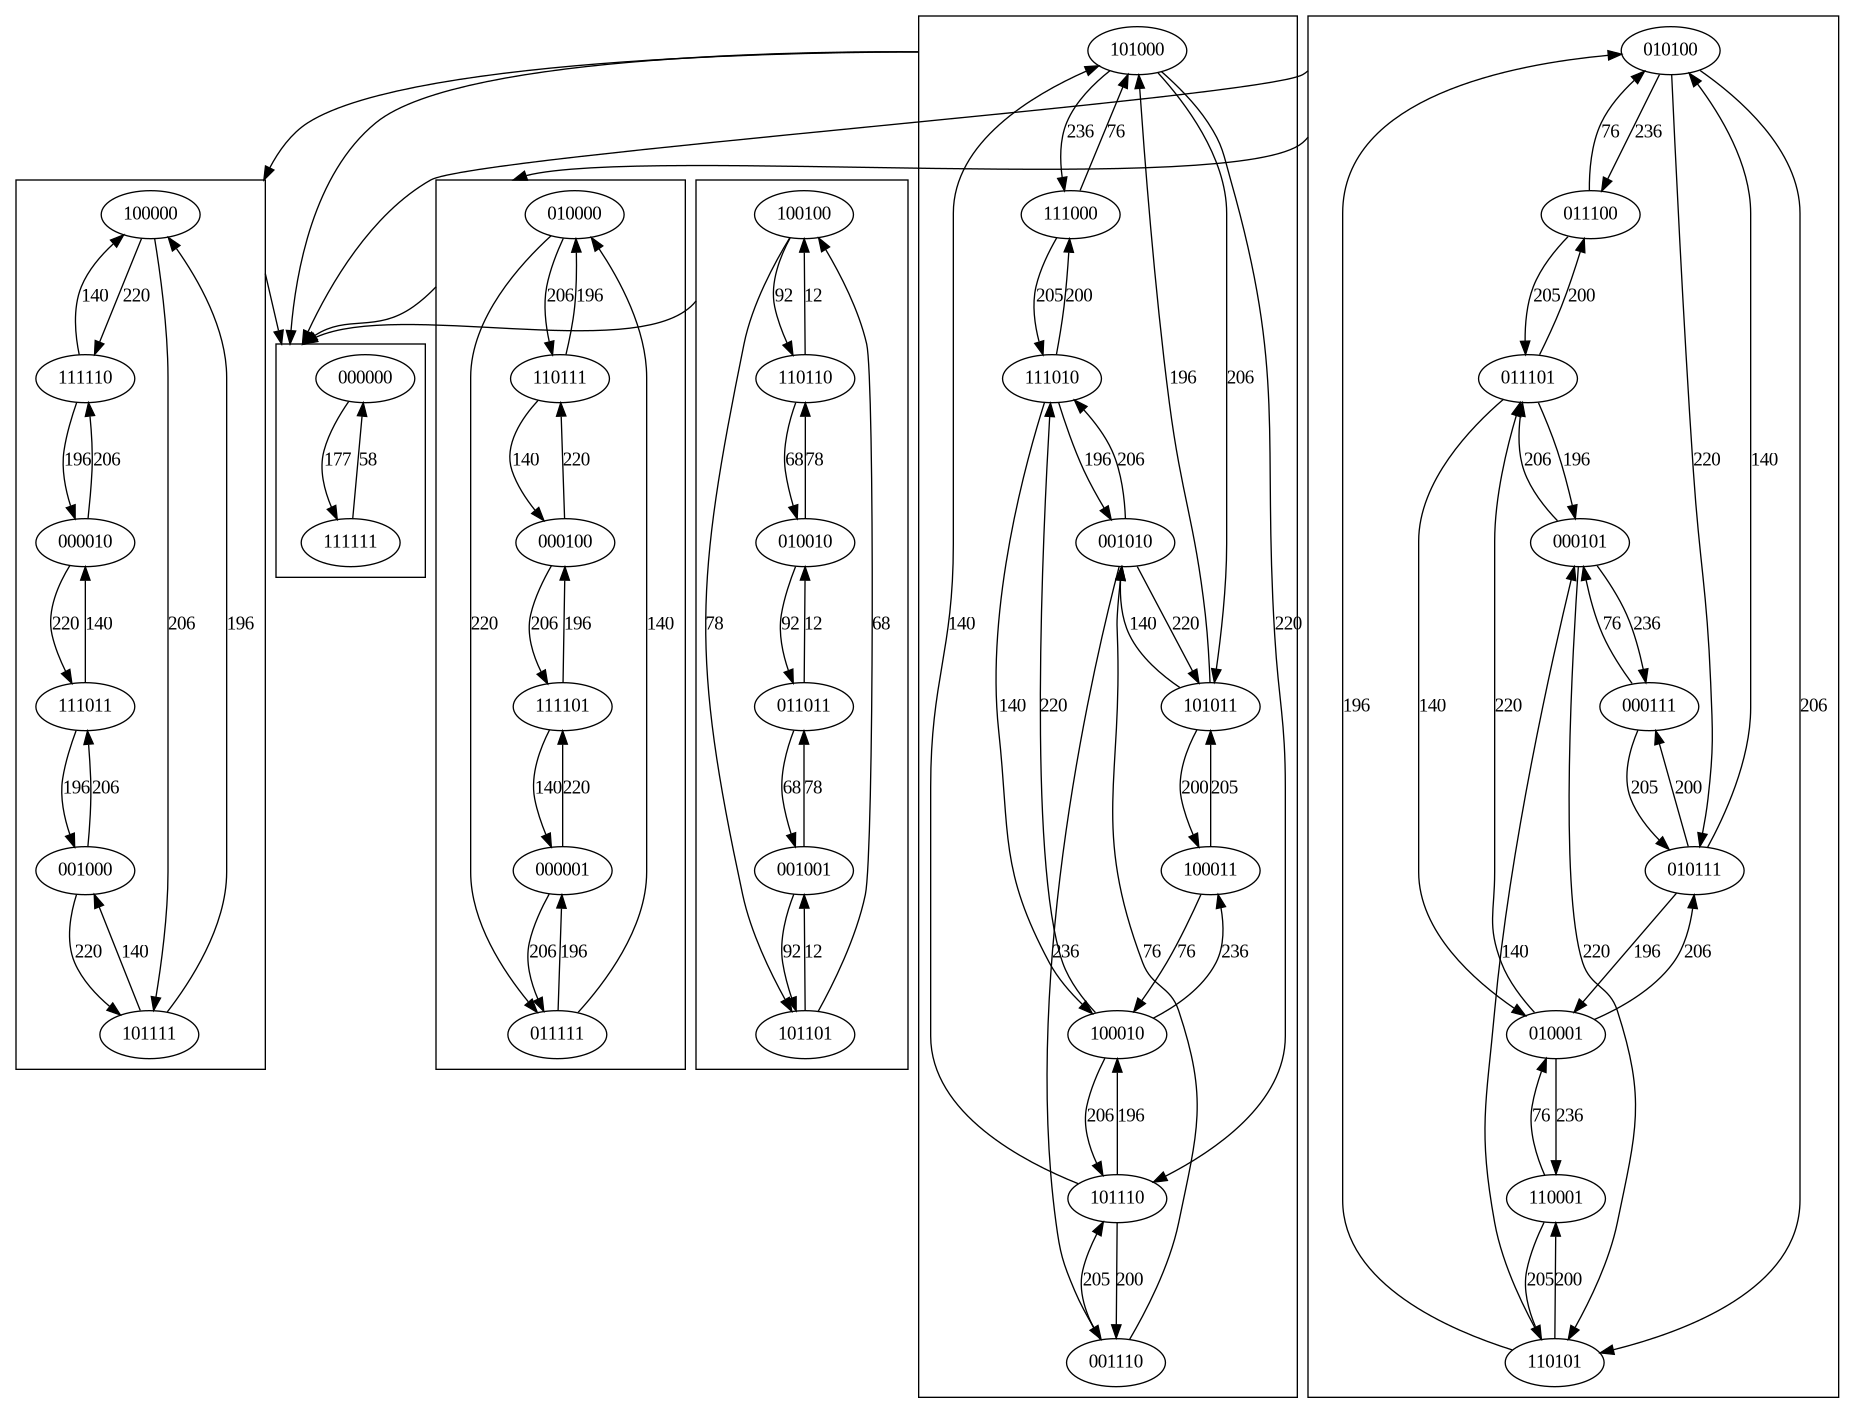

In [39]:
g = gv_compgraph_sccs(cg;
    # show_cond=false,
    skip_singles=true,
) |> attr(:graph; layout="dot", rankdir="TB")

## Testing ac condensation / splitting probabilities

In [7]:
ned = make_ca_ned(L, 76)
g = graph(ned)
acs = attracting_components(g)

K01 = [0 0; 0 0]
K10 = [0 0; 0 1]


21-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [17]
 [18]
 [19]
 [21]
 [22]
 [23]
 [25]
 [27]

Making a new graph which condenses all non-single-state acs into one new state

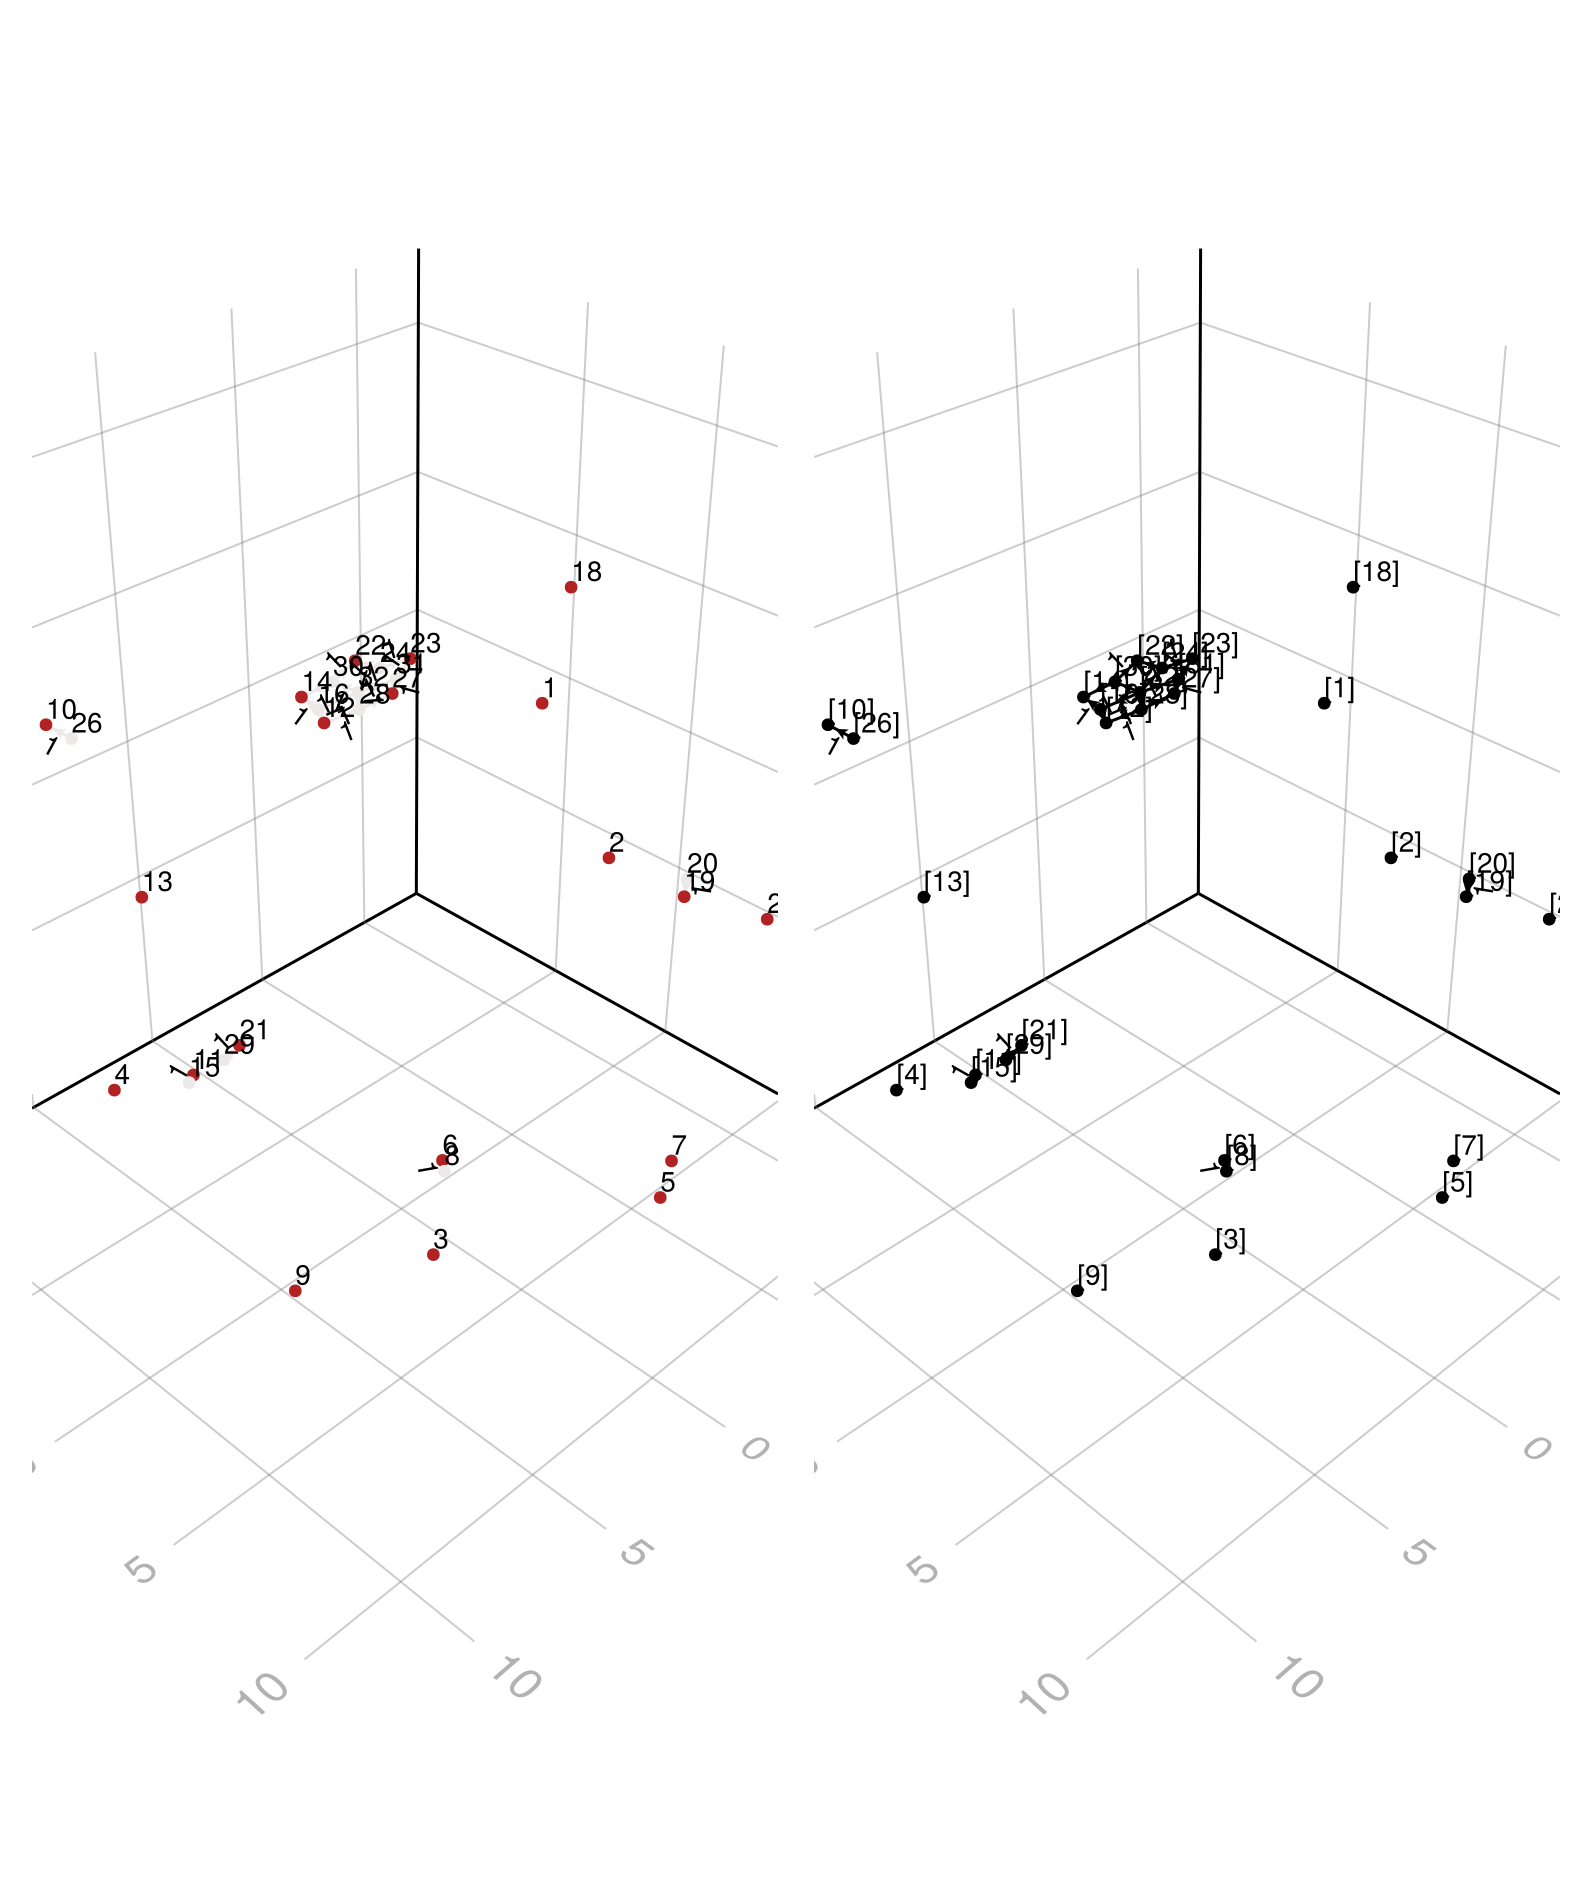

In [12]:
faa = viz_condense_acs(g)
display(GLMakie.Screen(), faa.figure)
faa.figure

Calculating the splitting probabilities directly

In [10]:
xx = make_splitprober_full(g)
@show xx(32)
@show xx(1)
@show xx(8)
@show xx(7)
@show xx(23)
nothing

xx(32) = [(0.2, [12]), (0.2, [14]), (0.2, [22]), (0.2, [23]), (0.2, [27])]
xx(1) = [(1.0, [1])]
xx(8) = [(1.0, [6])]
xx(7) = [(1.0, [7])]
xx(23) = [(1.0, [23])]


In [32]:
yy = make_splitprober(g)
yy(32, 27)

0.2

In [36]:
# Make sure this works for all codes!
for r in 0:255
    local ned = make_ca_ned(L, r; show=false)
    local g = graph(ned)
    spr = make_splitprober(g)
    # @show spr(1)
end

# First attempt

### Single code computation graphs

In [389]:
ma0sv1s_rules = [
    252, 184, 104 #, 168, 254, 174, 184, 166, 190, 160, 170, 182, 178, 162
]
xx = find_singlestateac_rules(5)[2:end]
nothing

In [390]:
codes = ma0sv1s_rules
# codes = xx
acs, sccgs = make_singlestate_ac_compgraphs(5, codes);

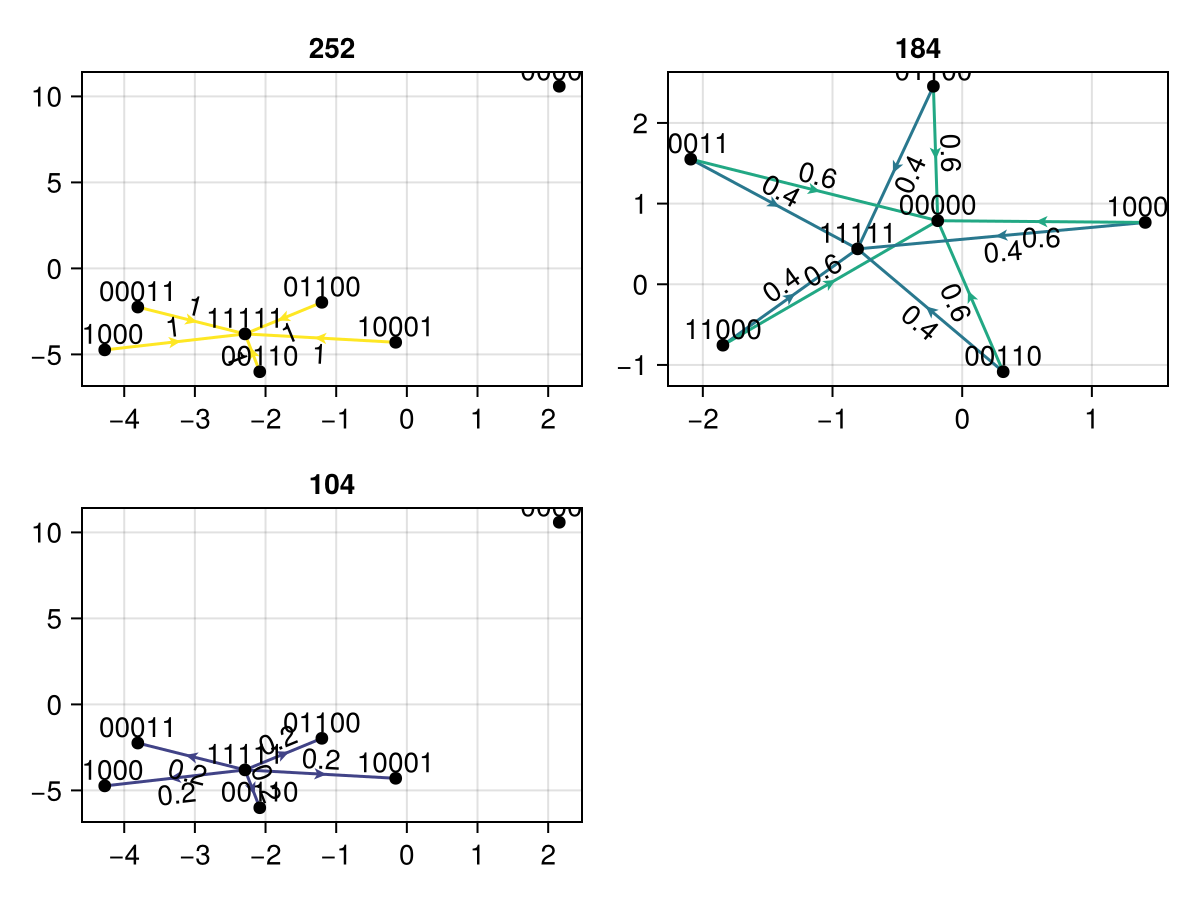

In [394]:
fig = Figure()

nplots = length(sccgs)
nrows, ncols = make_grid(nplots)
axs = [Axis(fig[ci.I[2], ci.I[1]]) for ci in CartesianIndices((ncols, nrows))[1:nplots]]

for (ax, acg, c) in zip(axs, sccgs, codes)
    metagraphplot!(ax, acg;
        nlabels_align=(:center, :bottom),
        edge_attr=(; colorrange=(0., 1.)),
        arrow_attr=(; colorrange=(0., 1.)),
    )
    ax.title = repr(c)
end

# display(GLMakie.Screen(), fig)
fig

### Merged/all codes computation graphs

In [422]:
# make the single code comp graphs
# codes = ma0sv1s_rules
# codes = ca_ucodes_f1()
codes = find_singlestateac_rules(5)[2:end]
acs, sccgs = make_singlestate_ac_compgraphs(5, codes;
    prob_threshold=0.9
);

trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 0.9999999999999998
trans_prob = 1.4999999999999998
trans_prob = 1.0
trans_prob = 0.9999999999999998
trans_prob = 1.4999999999999998
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0000000000000002
trans_prob = 1.0000000000000002
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0
trans_prob = 1.0000000000000002
trans_prob = 1.0
trans_prob = 0.9999999999999998
trans_prob = 

In [419]:
mcg = merge_sccgs(5, codes, sccgs)

Meta graph based on a SimpleDiGraph{Int64} with vertex labels of type Int64, vertex metadata of type String, edge metadata of type Tuple{Int64, Float64}, graph metadata given by "temp meta graph", and default weight 1.0

┌ Warning: Since there are a lot of edges (671 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/o2eDW/src/recipes.jl:547


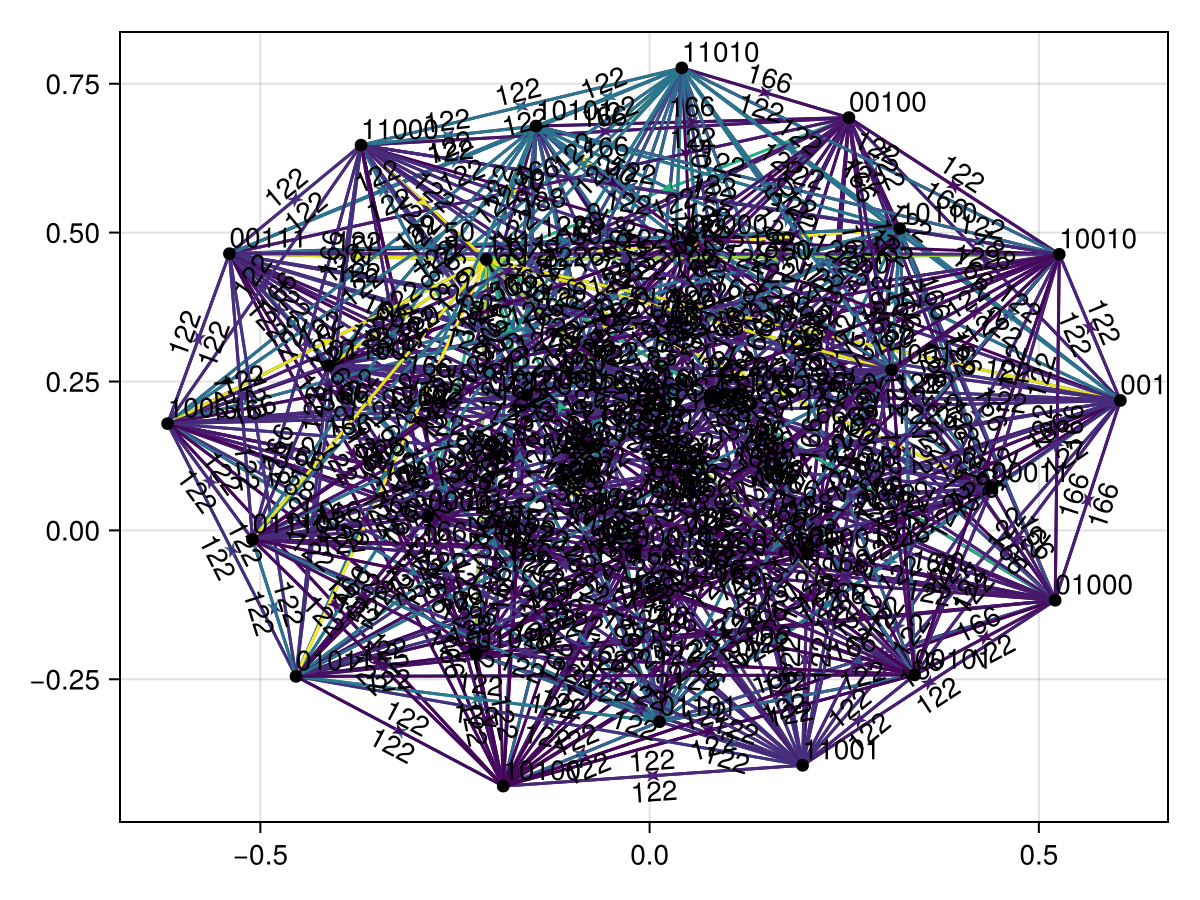

In [420]:
erules = [repr(mcg[src,dst][1]) for (src,dst) in edge_labels(mcg)]
eprobs = [mcg[src,dst][2] for (src,dst) in edge_labels(mcg)]
graphplot(mcg;
        nlabels=getindex.(Ref(mcg), labels(mcg)),
        elabels=erules,
        edge_color=eprobs,
)

# Bits and bobs

### Rules with single-state acs only

In [38]:
Ks_to_cacode([1 1; 1 1], [0 0; 0 0])

255

K01 = [1 1; 1 1]
K10 = [0 0; 0 0]


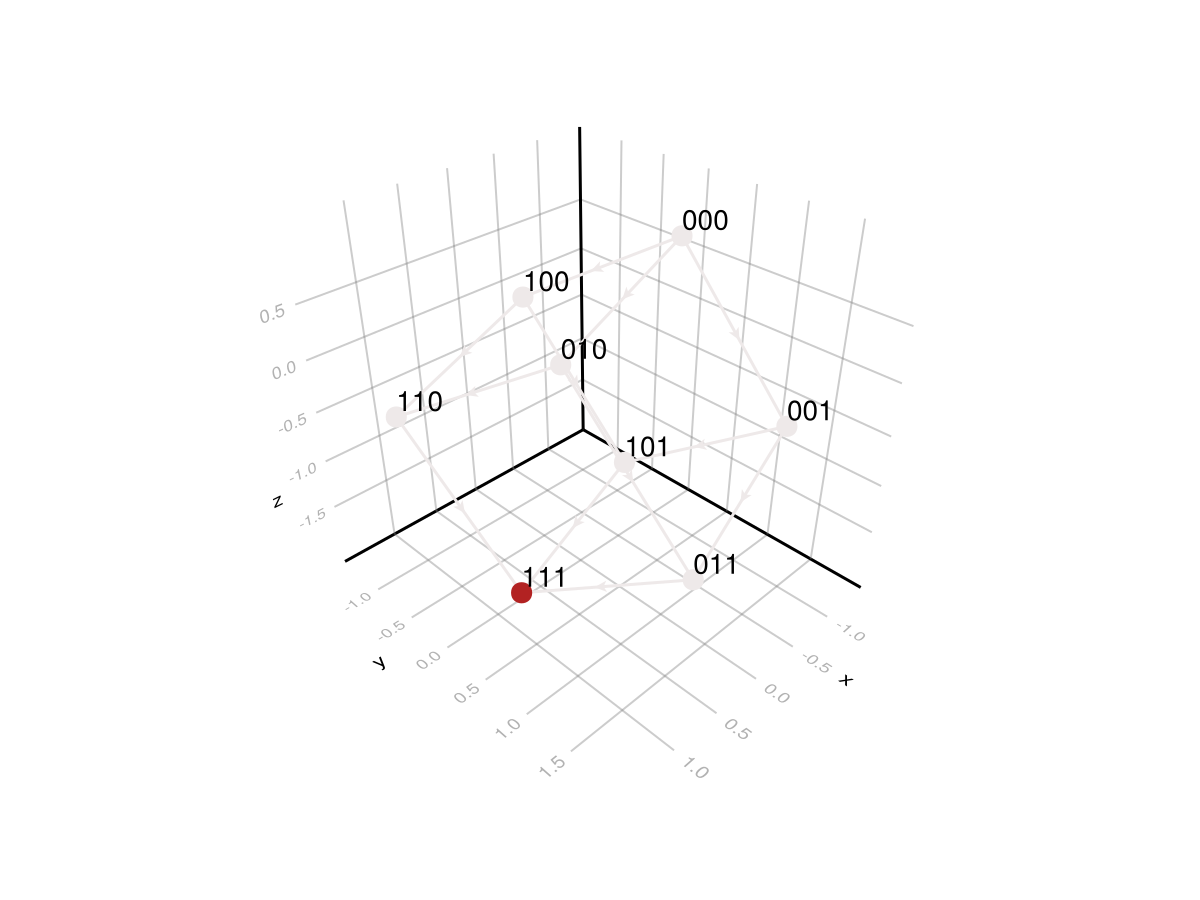

In [39]:
ned = make_ca_ned(L, 255)
faa = plotgm(ned;
    layout=Spring(dim=3),
    get_ac_coloring_kwargs(ned)...
)
display(GLMakie.Screen(), faa.figure)
faa.figure

In [40]:
@time xx = find_singlestateac_rules.(3:14);

 51.245697 seconds (85.55 M allocations: 14.346 GiB, 1.40% gc time)


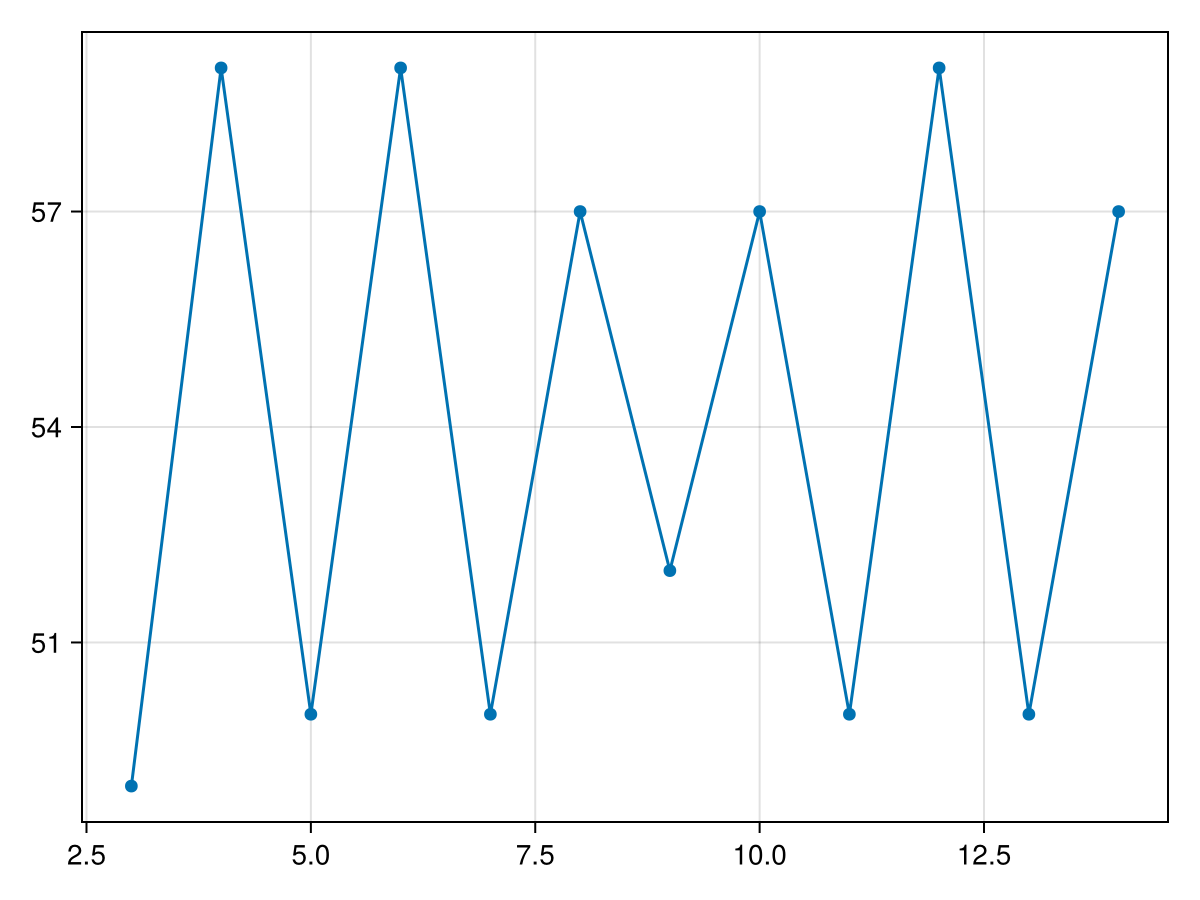

In [41]:
scatterlines(3:14, length.(xx))

In [2]:
GC.gc()
empty!(Out)
GC.gc()